# Проверка записи с открытыми закрытыми глазами

Цель:
- Проверить функции спектрального анализа
- Посмотреть на альфа ритм

Dataset: pilot/01_calib_sessions <br>
Date: 2025-12-20

In [1]:
# === project setup ===
from pathlib import Path
import sys

PROJECT_ROOT = Path().resolve().parents[0]
print("PROJECT_ROOT =", PROJECT_ROOT)

if not (PROJECT_ROOT / "src").exists():
    raise RuntimeError("src directory not found — wrong PROJECT_ROOT")

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

PROJECT_ROOT = C:\Users\hodor\Documents\lab-Shishkin\projects\feedback-quasi\analysis\fb-quasi_analysis


In [2]:
# === imports ===
from h5py import File 
import numpy as np 
import matplotlib.pyplot as plt 
import os
import copy
import importlib
import pandas as pd


In [3]:
from src.utils.parse_h5df import load_h5df
from src.utils.spectral_analysis import *
from src.utils.transformations import unit_to_db
from src.utils.montage_processing import *
from src.utils.rereferencing import *

In [4]:
# === config ===
DATASET = "pilot/01_calib_sessions"
SESSION = "02ES_ses10.12.2025_calib_v1.1"
DATA_FOLDER = os.path.join(r"..\data\raw\pilot\01_calib_sessions", SESSION, "data")
RECORD = "01-open-closed-eyes.hdf"

# open eyes - first half (~ 1 min)
# closed eyes - last half  (~ 1 min)

In [5]:
EEG_CHANNELS = np.arange(64)
CED_FILE = r"../resources/mks64_standard.ced"

ch_labels = get_channel_names(CED_FILE)

labels_ROA = ["PO7", "PO3", "POz", "PO4", "PO8",
              "O1", "Oz", "O2"]
idxs_ROA = [find_ch_idx(ch, CED_FILE) for ch in labels_ROA]

In [6]:
Fs = 1000 # Hz
s_to_idx = lambda x: int(x * Fs)
ms_to_idx = lambda x: int(x // 1000 * Fs)

In [7]:
# === data === 
data, _ = load_h5df(os.path.join(DATA_FOLDER, RECORD))
data.shape

(122928, 67)

In [8]:
# == preprocessing == 

# bandpass filter
raw_eeg = data[:-1, EEG_CHANNELS] * 1E6 # uV
filt_eeg = bandpass_filter(raw_eeg, fs=Fs, low=0.5, high=40)

In [9]:
# re-referencing Fz

idx_Fz = find_ch_idx("Fz", CED_FILE)
reref_eeg = rereference_eeg(filt_eeg, idx_Fz)

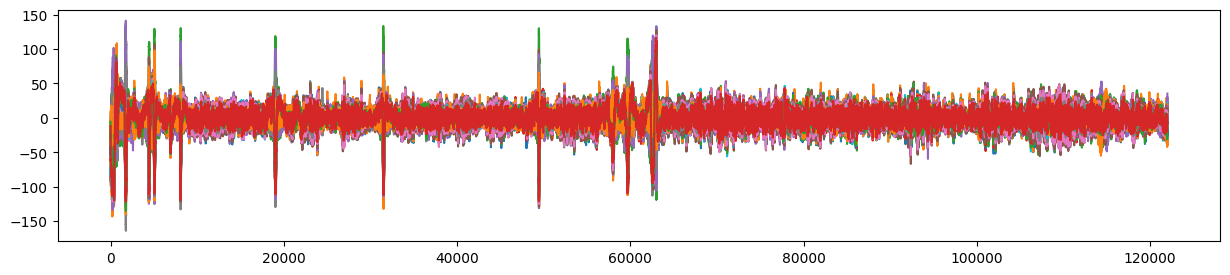

In [10]:
# == check signal == 
start_s, end_s = 0, raw_eeg.shape[0] // 1000 
start_idx, end_idx = s_to_idx(start_s), s_to_idx(end_s)
ch = 10
plt.figure(figsize=(15, 3))
plt.plot(filt_eeg[start_idx:end_idx]);

In [12]:
filt_eeg = reref_eeg

In [13]:
# === split data ===
idx_half = len(raw_eeg) // 2
eeg_opened = filt_eeg[:idx_half, :]       # opened eyes
eeg_closed = filt_eeg[idx_half:, :]       # closed eyes

In [14]:
# === spectral analysis ===

freq, psd_opened = compute_psd_welch(eeg_opened, fs=Fs, fmin=0.5, fmax=40, freq_res=.5)
freq, psd_closed = compute_psd_welch(eeg_closed, fs=Fs, fmin=0.5, fmax=40, freq_res=.5)

In [15]:
psd_db_opened = unit_to_db(psd_opened)
psd_db_closed = unit_to_db(psd_closed)

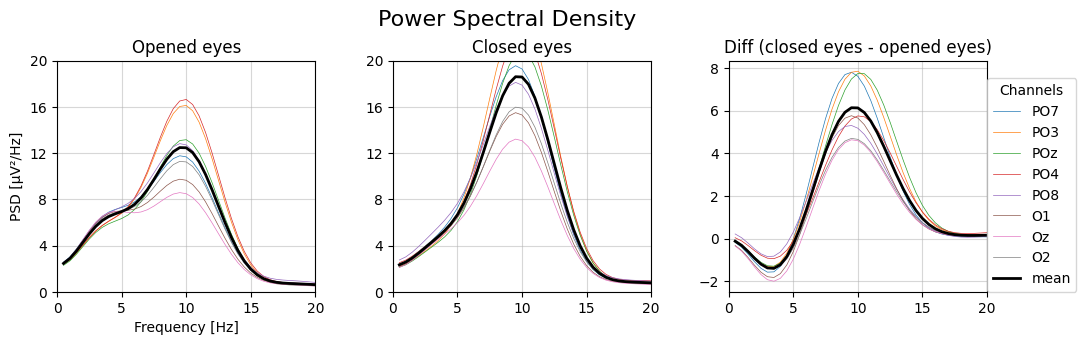

In [86]:
importlib.reload(src.visualization.check_alpha_rhythm)
from src.visualization.check_alpha_rhythm import plot_alpha_spectr

fig = plot_alpha_spectr(freq, psd_opened[idxs_ROA], psd_closed[idxs_ROA], labels_ROA,  plot_mean=True,
                 freq_min = 0, freq_max=20, to_db=False)

In [71]:
importlib.reload(src.utils.spectral_analysis)
from src.utils.spectral_analysis import compute_windowed_fft

f, t, S = compute_windowed_fft(reref_eeg, fs=Fs)

Text(80, 37, 'Closed eyes')

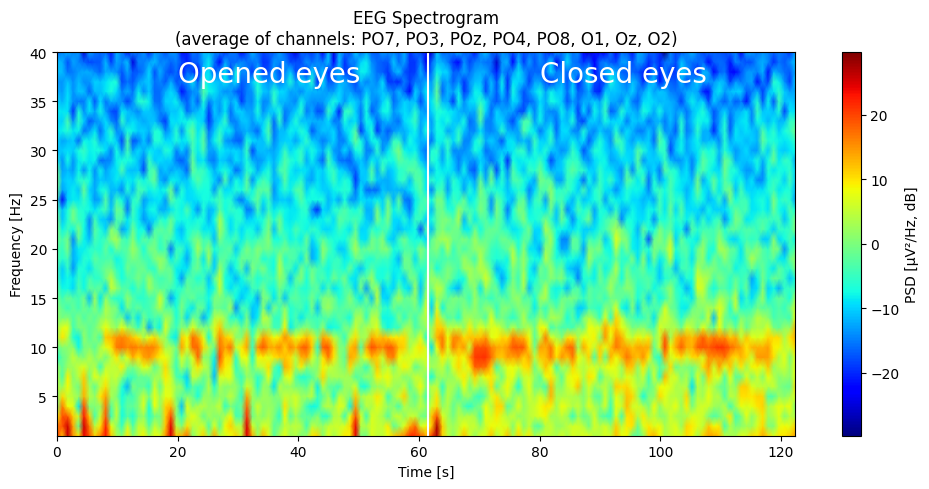

In [98]:
importlib.reload(src.visualization.spectrogram)
from src.visualization.spectrogram import plot_spectrogram


fig, ax = plot_spectrogram(f, t, S, 
                           average=True, channels=idxs_ROA,
                           fmin=1, fmax=40, 
                           title=f"EEG Spectrogram\n(average of channels: {', '.join(labels_ROA)})",
                           symmetric=True)
ax.axvline(idx_half / Fs, color='white')
ax.text(20, 37, "Opened eyes", color='white', fontsize=20)
ax.text(80, 37, "Closed eyes", color='white', fontsize=20)